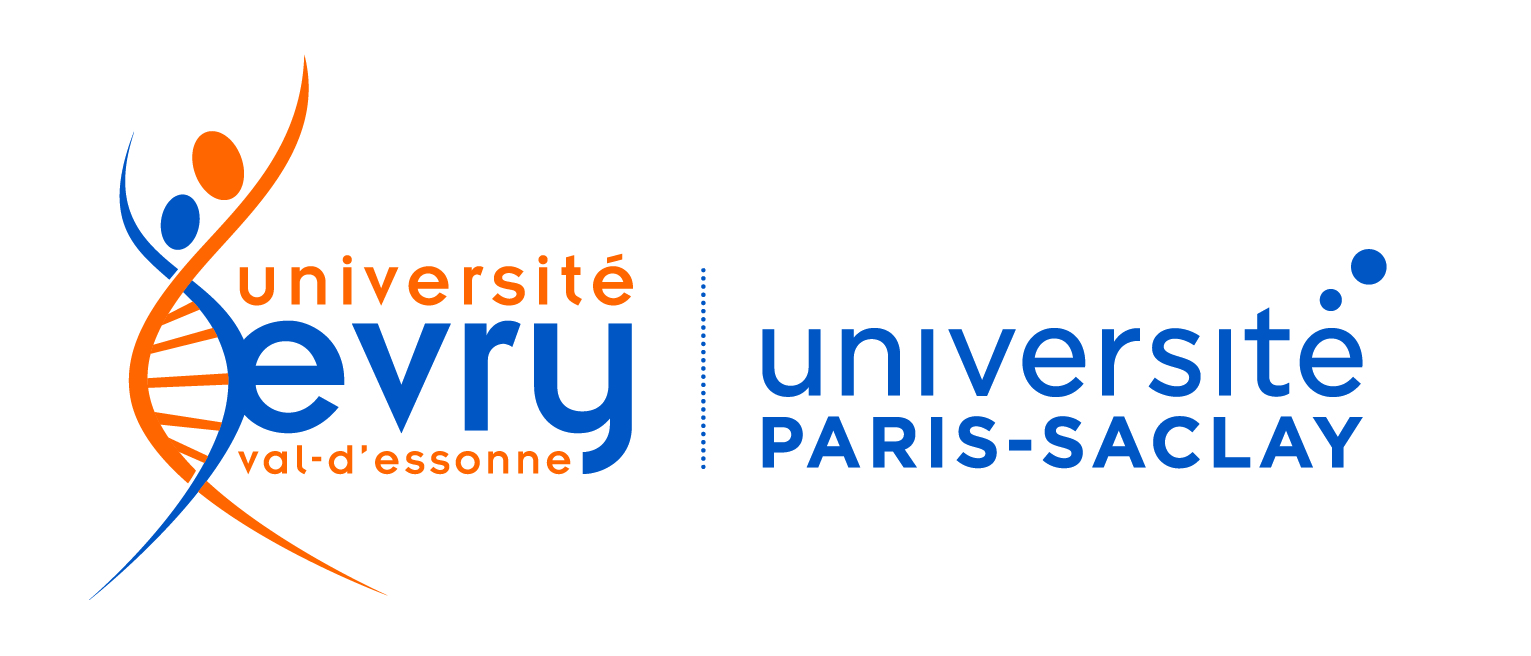

# Projet de Machine Learning
### Les membres du groupe:
    * Boufala Yacine
    * Fournier Jean-charles
    * Khalfoun Rayan
    * Zein Idoumou
   
    
### Responsables:
    * Jean Christophe janodet
    * Blaise Hanczar 

### Enoncé sur kaggle
#### Lien : https://www.kaggle.com/c/rossmann-store-sales/ 

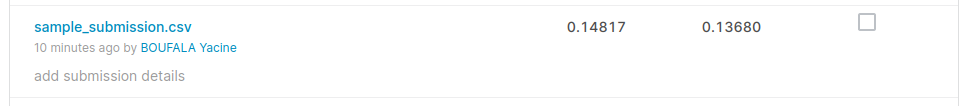

---

In [1]:
import numpy as np
import pandas as pd

# data visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Scaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

# Selector pour les colonne
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression as mr

# ML
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score


---

In [2]:
%time
submission = pd.read_csv('data/sample_submission.csv')
df_train = pd.read_csv('data/train.csv', low_memory=False)
df_test = pd.read_csv('data/test.csv', low_memory=False)
df_store = pd.read_csv('data/store.csv', low_memory=False)


CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


* Id - un Id qui représente un duple (Store, Date) dans le jeu de tests

* Store - un identifiant unique pour chaque magasin

* Ventes - le chiffre d'affaires pour un jour donné (c'est ce que vous prévoyez)

* Clients - le nombre de clients sur un jour donné

* Ouvert - un indicateur indiquant si le magasin était ouvert : 0 = fermé, 1 = ouvert

* StateHoliday - indique un jour férié. Normalement, tous les magasins, à quelques exceptions près, sont fermés les jours fériés. Notez que toutes les écoles sont fermées les jours fériés et les week-ends. 
    a="jour férié", 
    b="vacances de Pâques", 
    c="Noël", 
    0="Aucun"

* SchoolHoliday - indique si le (magasin, Date) a été affecté par la fermeture des écoles publiques

* StoreType- différencie 4 modèles de magasins différents : a, b, c, d

* Assortiment - décrit un niveau d'assortiment : a = basique, b = extra, c = étendu

* ConcurrenceDistance - distance en mètres jusqu'au magasin concurrent le plus proche

* ConcoursOuvertDepuis[Mois/Année] - donne l'année et le mois approximatifs de l'ouverture du concurrent le plus proche

* Promo - indique si un magasin organise une promo ce jour-là

* Promo2 - Promo2 est une promotion continue et consécutive pour certains magasins : 0 = le magasin ne participe pas, 1 = le magasin participe

* Promo2Since[Année/Semaine] - décrit l'année et la semaine civile au cours de laquelle le magasin a commencé à participer à Promo2

* PromoInterval - décrit les intervalles consécutifs Promo2 est démarré, en nommant les mois pendant lesquels la promotion est recommencée. Par ex. "Février, mai, août, novembre" signifie que chaque ronde commence en février, mai, août, novembre d'une année donnée pour ce magasin.

In [3]:
train = df_train.merge(df_store, how='left', on='Store')
test = df_test.merge(df_store, how='left', on='Store')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [5]:
print('Total : ', len(train))
print('closed stores : ', len(train[train['Open'] == 0]))
print('Open stores : ', len(train[train['Open'] == 1]))
print('proportion : ', len(train[train['Open'] == 0])/len(train))


Total :  1017209
closed stores :  172817
Open stores :  844392
proportion :  0.16989330609540418


In [6]:
train = train[train['Open'] == 1]
train.drop(['Open'], axis = 1, inplace=True)


In [7]:
str_cols = ['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval','CompetitionOpenSinceYear', 
            'CompetitionOpenSinceMonth']

for col in str_cols:
    train[col].fillna(0, inplace=True)
    test[col].fillna(0, inplace=True)
    

In [8]:
train['CompetitionDistance'].fillna(train['CompetitionDistance'].mean(), inplace = True)
test['CompetitionDistance'].fillna(test['CompetitionDistance'].mean(), inplace = True)


In [9]:
train.head(5)


,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,2015-07-31,6064,625,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,2015-07-31,4822,559,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


In [10]:
def split_date(df):
    
    df['Date'] = pd.to_datetime(df['Date'])
    df['WeekOfYear'] = df.Date.dt.isocalendar().week
    df['Year']= df.Date.dt.year

    mois = df.Date.dt.month
    jour = df.Date.dt.day

    
    moistab=[]
    for i in mois:
        if i == 12:
            moistab.append(1)
        elif i == 0 or i == 1:
            moistab.append(0)
        else:
            moistab.append(0.25)
    
    jourtab=[]
    for i in jour:
        if (i >= 1 and i <= 4) or i == 30:
            jourtab.append(1)
        elif (i >= 5 and i <= 7) or (i >= 16 and i <= 19) or i == 29 or i == 31:
            jourtab.append(0.5)
        else:
            jourtab.append(0)
        
    df['Month']= moistab
    df['Day'] = jourtab
    
split_date(train)
split_date(test)


Text(0.5, 1.0, 'Customers par Day')

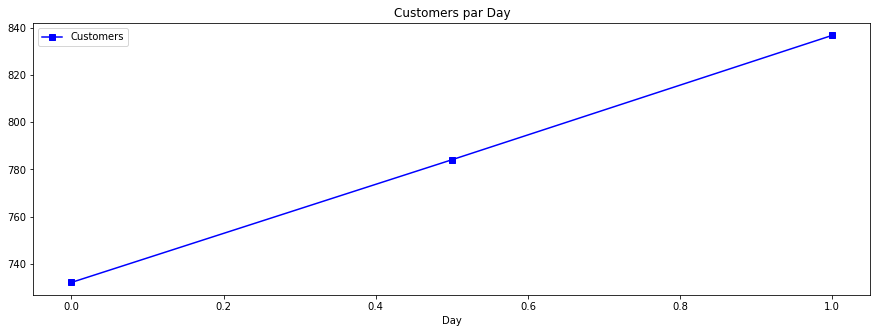

In [11]:
axis = train.groupby('Day')[['Customers']].mean().plot(figsize = (15,5), marker = 's', color = 'b')
axis.set_title('Customers par Day')


Text(0.5, 1.0, 'Customers par Month')

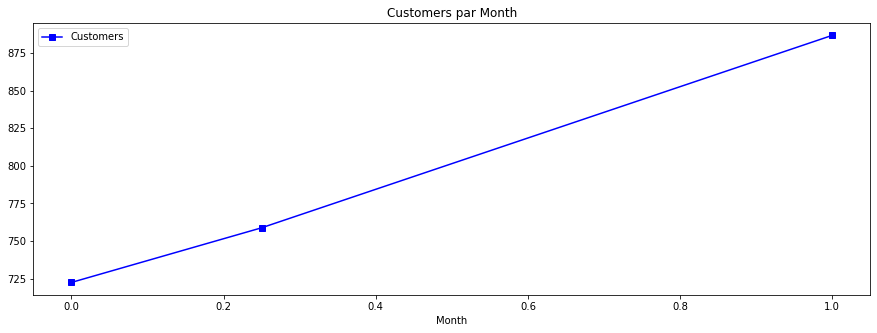

In [12]:
axis = train.groupby('Month')[['Customers']].mean().plot(figsize = (15,5), marker = 's', color = 'b')
axis.set_title('Customers par Month')


Text(0.5, 1.0, 'Customers par Year')

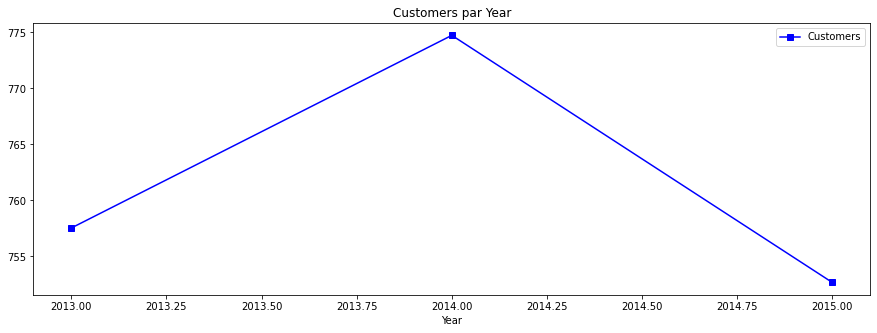

In [13]:
axis = train.groupby('Year')[['Customers']].mean().plot(figsize = (15,5), marker = 's', color = 'b')
axis.set_title('Customers par Year')


Text(0.5, 1.0, 'Customers par WeekOfYear')

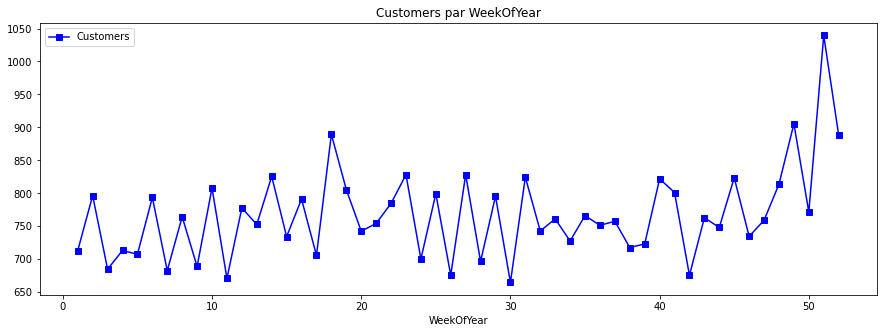

In [14]:
axis = train.groupby('WeekOfYear')[['Customers']].mean().plot(figsize = (15,5), marker = 's', color = 'b')
axis.set_title('Customers par WeekOfYear')


In [15]:
def scale_df(df):    
    df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
    df['CompetitionOpen'] = df['CompetitionOpen'].map(lambda x: 0 if x < 0 else x).fillna(0)
    
    # 1an = 365.25jours; moyenne = (365.25/12) = 30.5
    df['Promo2Open'] = 12*(df.Year-df.Promo2SinceYear) + (df.WeekOfYear - df.Promo2SinceWeek) * 7 / 30.5
    df['Promo2Open'] = df['Promo2Open'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']
    
scale_df(train)
scale_df(test)


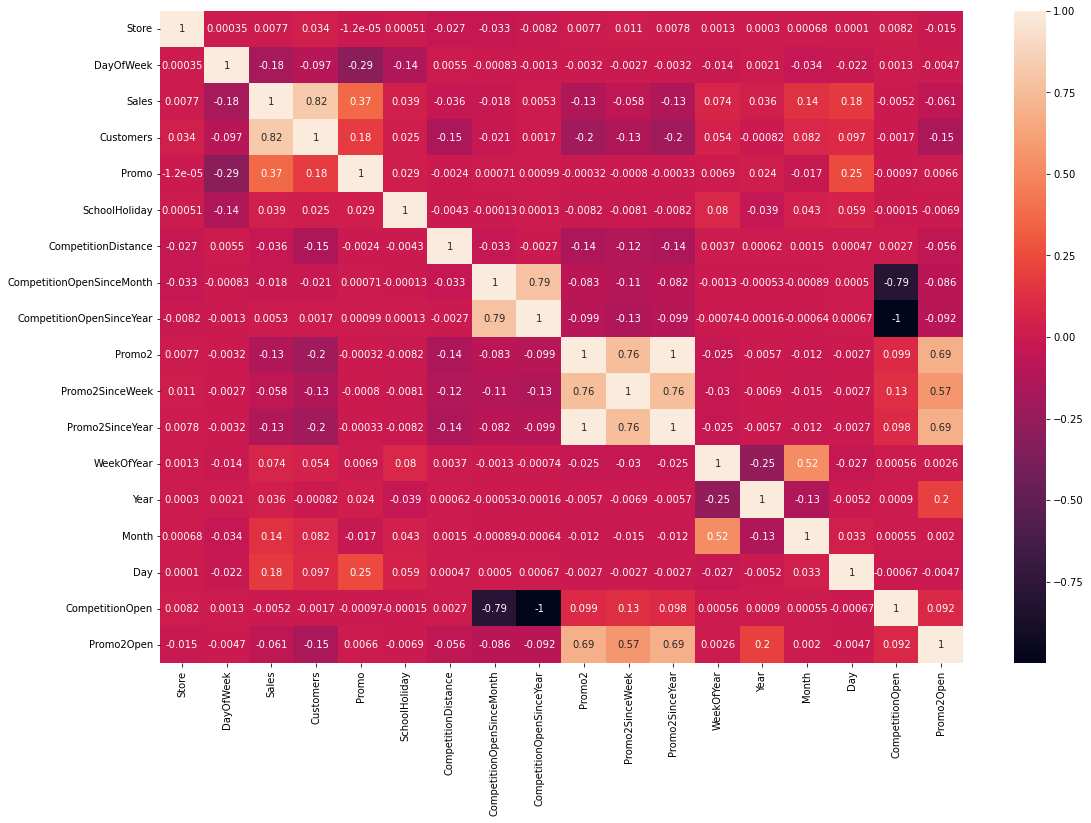

In [16]:
corr_df = train.corr(method='pearson')

plt.figure(figsize=(18, 12))
sns.heatmap(corr_df, annot=True)
plt.show()


In [17]:
cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 
        'CompetitionDistance', 'CompetitionOpenSinceYear', 'Promo2', 'Year', 'Month', 'Day', 'WeekOfYear', 
        'CompetitionOpen', 'Promo2Open']
target_col = 'Sales'

new_train = train[cols].copy().join(train[target_col])
new_test = test[cols].copy()


In [18]:
numeric_cols = ['Store', 'Promo', 'SchoolHoliday', 'DayOfWeek', 'CompetitionDistance', 'CompetitionOpen', 
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2Open', 'Day', 'Month', 'Year', 'WeekOfYear']

categorical_cols = ['StateHoliday', 'StoreType', 'Assortment']


In [19]:
%time
scaler = MinMaxScaler()
new_train[numeric_cols] = scaler.fit_transform(new_train[numeric_cols])
new_test[numeric_cols] = scaler.fit_transform(new_test[numeric_cols])
%time


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [20]:
%time
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(new_train[categorical_cols])
encoded_cols = list(encoder.get_feature_names(categorical_cols))

new_train[encoded_cols] = encoder.transform(new_train[categorical_cols])
new_test[encoded_cols] = encoder.transform(new_test[categorical_cols])
%time


CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs
CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.72 µs


In [21]:
new_train = new_train.drop(columns=categorical_cols, axis=1)
new_test = new_test.drop(columns=categorical_cols, axis=1)


---

In [22]:
y = new_train['Sales']
x = new_train.drop('Sales', axis=1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.001, random_state=42)


In [23]:
X_train.columns


Index(['Store', 'DayOfWeek', 'Promo', 'SchoolHoliday', 'CompetitionDistance',
       'CompetitionOpenSinceYear', 'Promo2', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'Promo2Open', 'StateHoliday_0',
       'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c', 'StoreType_a',
       'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_a',
       'Assortment_b', 'Assortment_c'],
      dtype='object')

---

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 10)]

max_depth = [int(x) for x in np.linspace(10, 120, num = 10)]
max_depth.append(None)
    
random_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
}

rf_random = RandomizedSearchCV(estimator=RandomForestRegressor(), 
                               param_distributions=random_grid, 
                               n_iter = 10, cv=2, n_jobs=7)

pipeline = Pipeline([('kbest', SelectKBest(score_func = mr)), ('lr', rf_random)]) 
grid_search = GridSearchCV(pipeline, {'kbest_k': [12, 14, 16, 17, 18]}) 

# grid_search.fit(X_train, y_train)


---

In [25]:
select = SelectKBest(score_func = mr, k=14)
select.fit_transform(X_train, y_train)

kept_features = pd.DataFrame({'columns': X_train.columns, 'gardée': select.get_support()})
kept_features[kept_features.gardée == True]


,columns,gardée
0,Store,True
1,DayOfWeek,True
2,Promo,True
4,CompetitionDistance,True
5,CompetitionOpenSinceYear,True
6,Promo2,True
8,Month,True
9,Day,True
10,WeekOfYear,True
11,CompetitionOpen,True


In [26]:
new_X_train = X_train.iloc[:, select.get_support()]
new_X_test = X_test.iloc[:, select.get_support()]

new_X_new_test = new_test.iloc[:, select.get_support()]


In [27]:
new_X_train.head(5)


,Store,DayOfWeek,Promo,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Month,Day,WeekOfYear,CompetitionOpen,Promo2Open,StoreType_d,Assortment_a,Assortment_c
385223,0.198384,0.666667,0.0,0.028349,0.996526,0.0,0.25,0.0,0.568627,0.002533,0.000000,0.0,1.0,0.0
1003985,0.139138,0.833333,0.0,0.026371,0.998015,1.0,0.00,0.0,0.019608,0.000910,0.295082,0.0,1.0,0.0
896445,0.691203,0.666667,0.0,0.271888,0.996030,0.0,0.25,0.5,0.294118,0.002616,0.000000,0.0,1.0,0.0
255017,0.934470,0.666667,0.0,0.045095,0.000000,1.0,1.00,0.0,0.960784,0.999535,0.227231,0.0,1.0,0.0
798918,0.222621,0.000000,1.0,0.237210,0.999504,0.0,0.25,0.0,0.549020,0.000000,0.000000,1.0,0.0,1.0


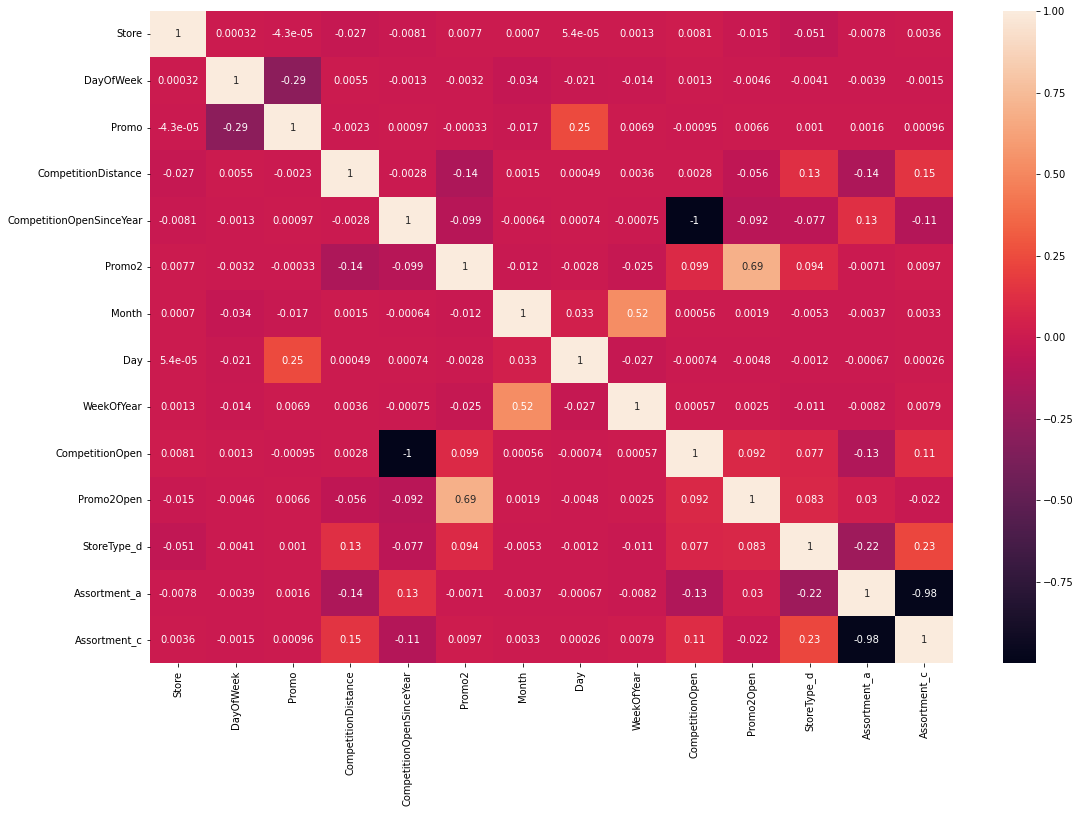

In [28]:
corr_df = new_X_train.corr(method='pearson')

plt.figure(figsize=(18, 12))
sns.heatmap(corr_df, annot=True)
plt.show()


array([[<AxesSubplot:title={'center':'Store'}>,
        <AxesSubplot:title={'center':'DayOfWeek'}>,
        <AxesSubplot:title={'center':'Promo'}>,
        <AxesSubplot:title={'center':'CompetitionDistance'}>],
       [<AxesSubplot:title={'center':'CompetitionOpenSinceYear'}>,
        <AxesSubplot:title={'center':'Promo2'}>,
        <AxesSubplot:title={'center':'Month'}>,
        <AxesSubplot:title={'center':'Day'}>],
       [<AxesSubplot:title={'center':'WeekOfYear'}>,
        <AxesSubplot:title={'center':'CompetitionOpen'}>,
        <AxesSubplot:title={'center':'Promo2Open'}>,
        <AxesSubplot:title={'center':'StoreType_d'}>],
       [<AxesSubplot:title={'center':'Assortment_a'}>,
        <AxesSubplot:title={'center':'Assortment_c'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

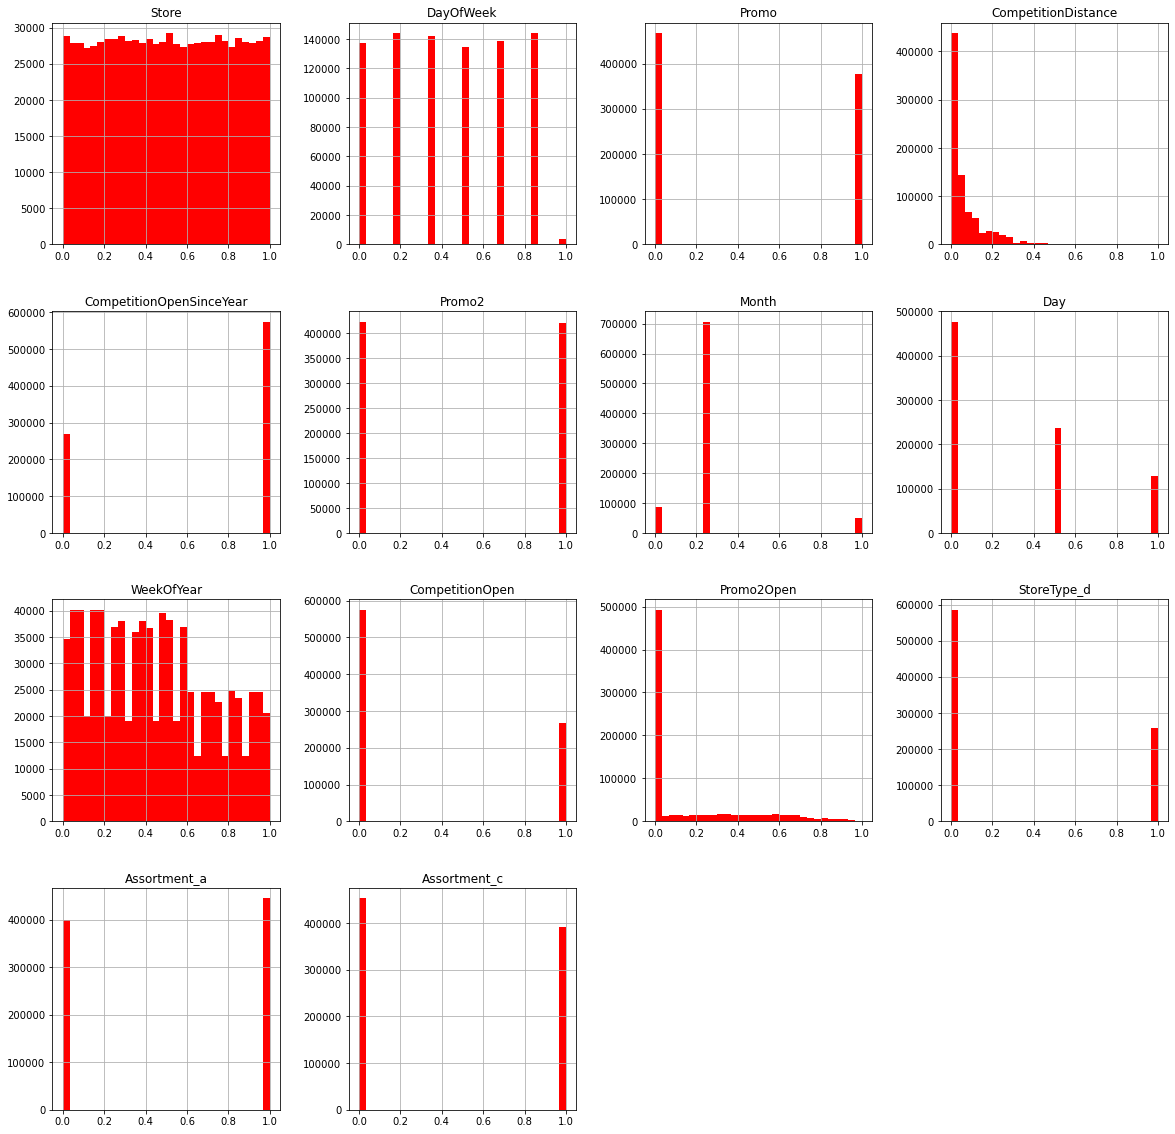

In [29]:
new_X_train.hist(bins = 30, figsize=(20,20), color = 'r')


In [30]:
%time
model = RandomForestRegressor(max_depth = 90, n_estimators = 300, n_jobs = 7)
model.fit(new_X_train, y_train)
%time


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


In [31]:
%time
y_pred = model.predict(new_X_test)
%time


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 5.96 µs
CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.9 µs


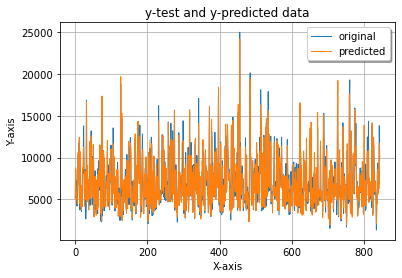

Score:  90.8938126776727 %


In [32]:
plt.plot(range(len(y_test)), y_test, linewidth=1, label="original")
plt.plot(range(len(y_test)), y_pred, linewidth=1, label="predicted")
plt.title("y-test and y-predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

print("Score: ", r2_score(y_test, y_pred)*100, "%")


In [33]:
y_pred_test = model.predict(new_X_new_test)
print(len(y_pred_test))
submission['Sales'] = y_pred_test
submission.to_csv('data/sample_submission_k14.csv', index = None)


41088


---

In [35]:
select = SelectKBest(score_func = mr, k=17)
select.fit_transform(X_train, y_train)

kept_features = pd.DataFrame({'columns': X_train.columns, 'gardée': select.get_support()})
kept_features[kept_features.gardée == True]


,columns,gardée
0,Store,True
1,DayOfWeek,True
2,Promo,True
3,SchoolHoliday,True
4,CompetitionDistance,True
5,CompetitionOpenSinceYear,True
6,Promo2,True
8,Month,True
9,Day,True
10,WeekOfYear,True


In [36]:
new_X_train = X_train.iloc[:, select.get_support()]
new_X_test = X_test.iloc[:, select.get_support()]

new_X_new_test = new_test.iloc[:, select.get_support()]


In [37]:
new_X_train.head(5)


,Store,DayOfWeek,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Month,Day,WeekOfYear,CompetitionOpen,Promo2Open,StoreType_a,StoreType_b,StoreType_d,Assortment_a,Assortment_c
385223,0.198384,0.666667,0.0,1.0,0.028349,0.996526,0.0,0.25,0.0,0.568627,0.002533,0.000000,1.0,0.0,0.0,1.0,0.0
1003985,0.139138,0.833333,0.0,0.0,0.026371,0.998015,1.0,0.00,0.0,0.019608,0.000910,0.295082,1.0,0.0,0.0,1.0,0.0
896445,0.691203,0.666667,0.0,0.0,0.271888,0.996030,0.0,0.25,0.5,0.294118,0.002616,0.000000,1.0,0.0,0.0,1.0,0.0
255017,0.934470,0.666667,0.0,0.0,0.045095,0.000000,1.0,1.00,0.0,0.960784,0.999535,0.227231,1.0,0.0,0.0,1.0,0.0
798918,0.222621,0.000000,1.0,1.0,0.237210,0.999504,0.0,0.25,0.0,0.549020,0.000000,0.000000,0.0,0.0,1.0,0.0,1.0


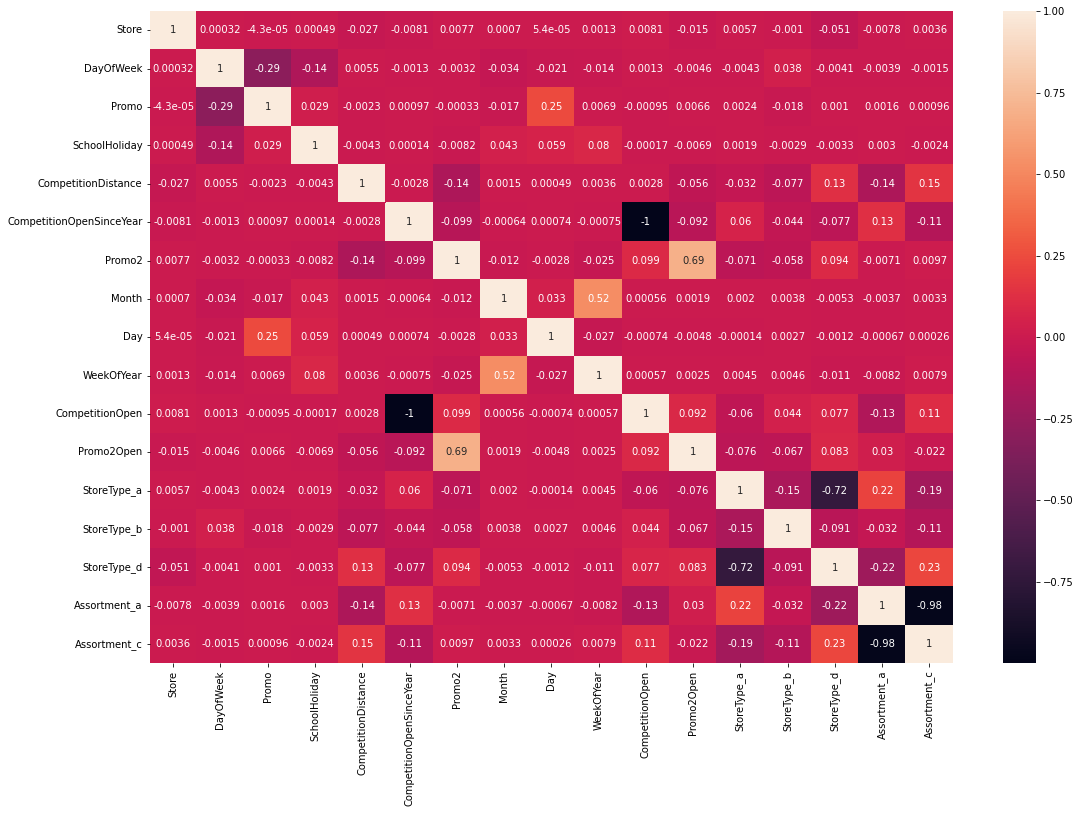

In [38]:
corr_df = new_X_train.corr(method='pearson')

plt.figure(figsize=(18, 12))
sns.heatmap(corr_df, annot=True)
plt.show()


array([[<AxesSubplot:title={'center':'Store'}>,
        <AxesSubplot:title={'center':'DayOfWeek'}>,
        <AxesSubplot:title={'center':'Promo'}>,
        <AxesSubplot:title={'center':'SchoolHoliday'}>],
       [<AxesSubplot:title={'center':'CompetitionDistance'}>,
        <AxesSubplot:title={'center':'CompetitionOpenSinceYear'}>,
        <AxesSubplot:title={'center':'Promo2'}>,
        <AxesSubplot:title={'center':'Month'}>],
       [<AxesSubplot:title={'center':'Day'}>,
        <AxesSubplot:title={'center':'WeekOfYear'}>,
        <AxesSubplot:title={'center':'CompetitionOpen'}>,
        <AxesSubplot:title={'center':'Promo2Open'}>],
       [<AxesSubplot:title={'center':'StoreType_a'}>,
        <AxesSubplot:title={'center':'StoreType_b'}>,
        <AxesSubplot:title={'center':'StoreType_d'}>,
        <AxesSubplot:title={'center':'Assortment_a'}>],
       [<AxesSubplot:title={'center':'Assortment_c'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

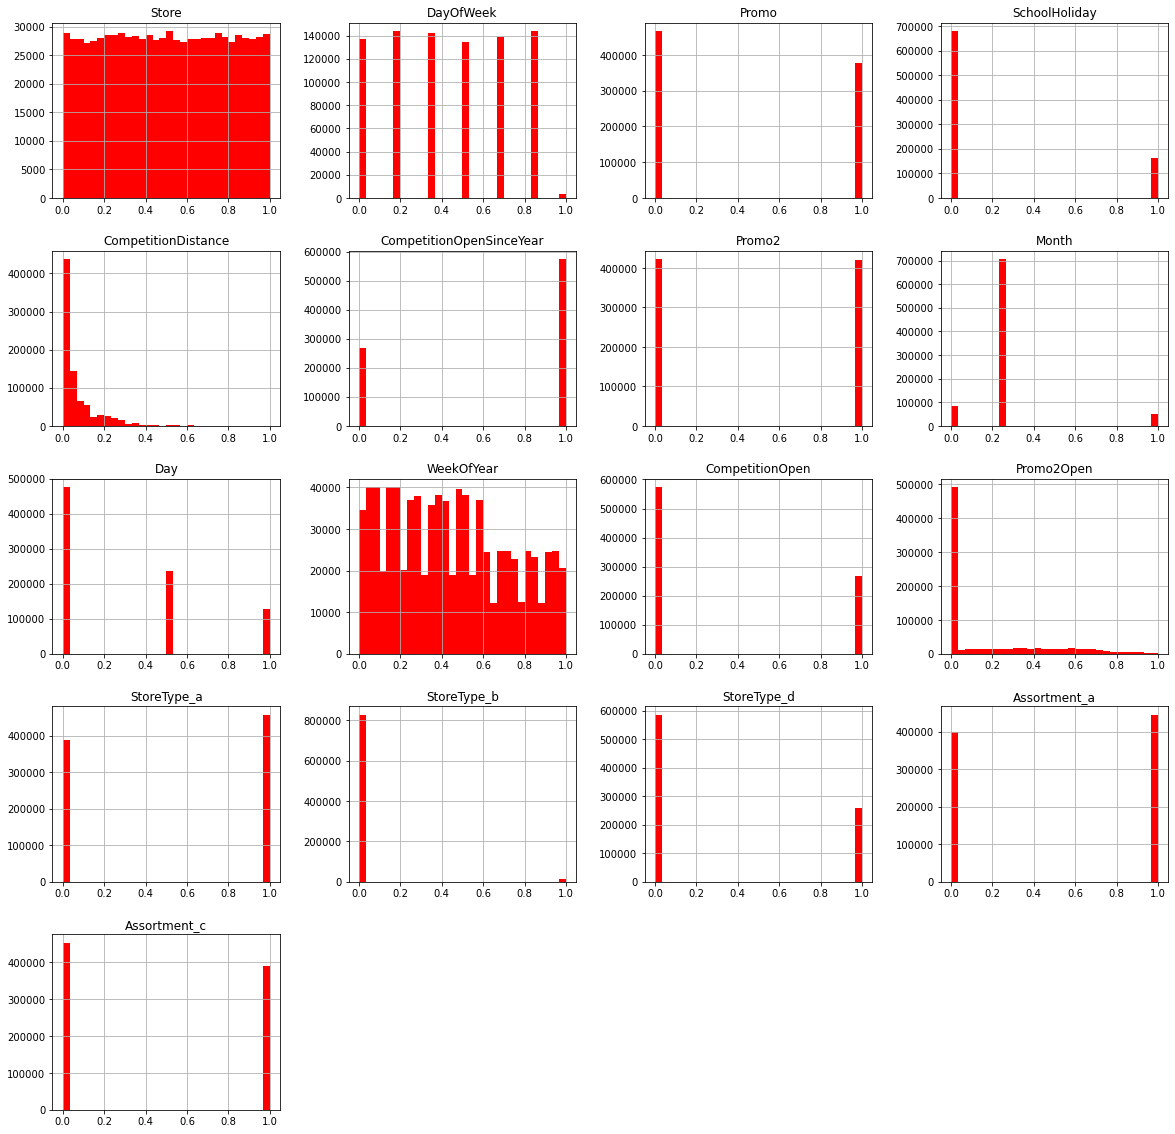

In [39]:
new_X_train.hist(bins = 30, figsize=(20,20), color = 'r')


In [40]:
%time
model = RandomForestRegressor(max_depth = 90, n_estimators = 300, n_jobs = 7)
model.fit(new_X_train, y_train)
%time


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [41]:
%time
y_pred = model.predict(new_X_test)
%time


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs
CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10 µs


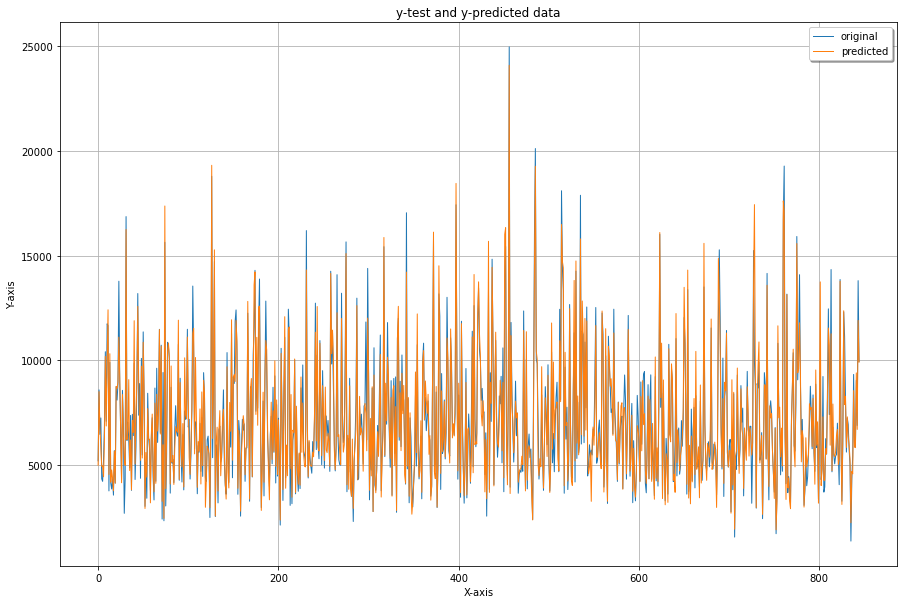

Score:  91.44616751210998 %


In [42]:
plt.plot(range(len(y_test)), y_test, linewidth=1, label="original")
plt.plot(range(len(y_test)), y_pred, linewidth=1, label="predicted")
plt.title("y-test and y-predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

print("Score: ", r2_score(y_test, y_pred)*100, "%")


In [43]:
y_pred_test = model.predict(new_X_new_test)
print(len(y_pred_test))
submission['Sales'] = y_pred_test
submission.to_csv('data/sample_submission_k17.csv', index = None)


41088


---